In [1]:
import os
import sys
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Scoring
import shap
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
computed_features = 'data/data_202110/hjolli_bin_df1.csv'           
jaspar = 'data/data_202110/hjolli_motifs1.csv' 
motifs_file = 'data/data_202110/hjolli_motifs_score1.csv'
informations = 'data/data_202110/hjolli1.csv'
sequence = 'data/hjolli_dataset_robin_value_600.csv'

In [3]:
df_cf = pd.read_csv(computed_features, sep=',')
df_jaspar = pd.read_csv(jaspar, sep=',')
df_seq = pd.read_csv(sequence, sep='\t')
df_cf = df_cf.drop(columns='Unnamed: 0')
df_cf = df_cf.drop(columns='n_motif_bin')

motifs = pd.read_csv(motifs_file, sep=',')
cage_i = pd.read_csv(informations, sep=',')

info_ = pd.concat([motifs, df_cf], axis=1)
info_.rename(columns={'Unnamed: 0':'thick.names'}, inplace=True)
df_jaspar.rename(columns={'Unnamed: 0':'thick.names'}, inplace=True)

In [4]:
df_seq.head()

,Region,Sequence,geneID,txType,adjusted_log10_CV2,CGI_TATA_status,Chr,Class_,Len,Fold
0,chr1:628938-629538,CCTCCTGGCTTAGCCTGGATCGTTTGAAATGGTCATCCATCCTTTG...,ENSG00000225972.1,promoter,0.993507,TATA,chr1,1.0,600,0
1,chr1:629214-629814,TATAACGCACTCTCCCCTGAACTCTACACAACATATTTTGTCACCA...,ENSG00000225630.1,promoter,1.515555,TATA,chr1,1.0,600,0
2,chr1:629965-630565,CCCCTTTCACTTCTGAGTCCCAGAGGTTACCCAAGGCACCCCTCTG...,ENSG00000225630.1,promoter,0.539849,TATA,chr1,1.0,600,0
3,chr1:631050-631650,GCCATTTTACCTCACCCCCACTGATGTTCGCCGACCGTTGACTATT...,ENSG00000237973.1,promoter,0.947539,TATA,chr1,1.0,600,0
4,chr1:632143-632743,TATTAGCAAACTCATCACTAGACATCGTACTACACGACACGTACTA...,ENSG00000229344.1,promoter,0.483100,TATA,chr1,1.0,600,0


In [5]:
cage_i['adjusted_log10_CV2'].quantile([0.25, 0.30, 0.50, 0.75])

0.25   -0.149008
0.30   -0.115816
0.50   -0.000232
0.75    0.192239
Name: adjusted_log10_CV2, dtype: float64

# define low vs high variable promoter based on quartile

In [6]:
#cage_i.loc[cage_i['adjusted_log10_CV2'] <= -0.149008, 'Class_'] = 0
#cage_i.loc[cage_i['adjusted_log10_CV2'] >= 0.192239, 'Class_'] = 1

cage_i.loc[cage_i['adjusted_log10_CV2'] <= -0.20, 'Class_'] = 0
cage_i.loc[cage_i['adjusted_log10_CV2'] >= 0.25, 'Class_'] = 1
cage_i["log10_median"] = np.log(cage_i['median']+1)
promoter_variability = cage_i.dropna()

In [7]:
promoter_variability#.head()

,seqnames,start,end,width,strand,score,thick.start,thick.end,thick.width,thick.names,...,log10_CV2,roll_median_log10_CV2,adjusted_log10_CV2,entropy,IQR,PhastCon,CpG,CpG.obsexp,Class_,log10_median
0,chr1,629079,629397,319,+,134749,629129,629129,1,chr1:629079-629397;+,...,0.091610,-0.901897,0.993507,5.835915,70,0.554232,1,0.545710,1.0,3.692134
1,chr1,629472,629557,86,+,5761,629504,629504,1,chr1:629472-629557;+,...,1.184311,-0.331244,1.515555,1.592665,0,0.779070,1,0.626652,1.0,0.679697
2,chr1,629627,630904,1278,+,895012,630752,630752,1,chr1:629627-630904;+,...,-0.275050,-0.814899,0.539849,7.010044,467,0.430908,1,0.596374,1.0,5.725004
3,chr1,631043,631657,615,+,1706302,631073,631073,1,chr1:631043-631657;+,...,0.116025,-0.831514,0.947539,5.452198,404,0.798862,1,0.532787,1.0,6.142378
4,chr1,631719,633168,1450,+,2302901,632759,632759,1,chr1:631719-633168;+,...,-0.294915,-0.778016,0.483100,5.843819,813,0.754000,1,0.944569,1.0,6.688405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28996,chrY,3002785,3002802,18,-,430,3002800,3002800,1,chrY:3002785-3002802;-,...,0.457156,0.182526,0.274631,2.813931,9,0.100000,0,0.172706,1.0,0.000000
28997,chrY,13479297,13479640,344,-,3929,13479394,13479394,1,chrY:13479297-13479640;-,...,0.135404,-0.283890,0.419294,5.604833,208,0.515116,1,0.766638,1.0,0.319594
28998,chrY,13479736,13480187,452,-,80120,13480009,13480009,1,chrY:13479736-13480187;-,...,0.110042,-0.827568,0.937610,5.438725,38,0.391372,1,0.727008,1.0,1.283370
28999,chrY,19077321,19077546,226,-,1180,19077494,19077494,1,chrY:19077321-19077546;-,...,0.616186,-0.149215,0.765401,4.481117,62,0.249115,1,0.801282,1.0,0.000000


In [8]:
promoter_variability['new_start'] = ((promoter_variability.start+promoter_variability.end)//2)-300
promoter_variability['new_end'] = ((promoter_variability.start+promoter_variability.end)//2)+300

In [9]:
promoter_variability['Region'] = promoter_variability.agg('{0[seqnames]}:{0[new_start]}-{0[new_end]}'.format, axis=1)

In [10]:
promoter_variability_tmp = promoter_variability[['Region','thick.names', 'seqnames', 'geneID', 'log10_median','median','adjusted_log10_CV2','Class_']]
promoter_variability_tmp

,Region,thick.names,seqnames,geneID,log10_median,median,adjusted_log10_CV2,Class_
0,chr1:628938-629538,chr1:629079-629397;+,chr1,ENSG00000225972.1,3.692134,39.130407,0.993507,1.0
1,chr1:629214-629814,chr1:629472-629557;+,chr1,ENSG00000225630.1,0.679697,0.973279,1.515555,1.0
2,chr1:629965-630565,chr1:629627-630904;+,chr1,ENSG00000225630.1,5.725004,305.434634,0.539849,1.0
3,chr1:631050-631650,chr1:631043-631657;+,chr1,ENSG00000237973.1,6.142378,464.158444,0.947539,1.0
4,chr1:632143-632743,chr1:631719-633168;+,chr1,ENSG00000229344.1,6.688405,802.040196,0.483100,1.0
...,...,...,...,...,...,...,...,...
28996,chrY:3002493-3003093,chrY:3002785-3002802;-,chrY,ENSG00000233070.1,0.000000,0.000000,0.274631,1.0
28997,chrY:13479168-13479768,chrY:13479297-13479640;-,chrY,ENSG00000183878.15,0.319594,0.376568,0.419294,1.0
28998,chrY:13479661-13480261,chrY:13479736-13480187;-,chrY,ENSG00000183878.15,1.283370,2.608779,0.937610,1.0
28999,chrY:19077133-19077733,chrY:19077321-19077546;-,chrY,ENSG00000176728.7,0.000000,0.000000,0.765401,1.0


# merge dataframes to have all info in one place

In [11]:
final_df_tmp = promoter_variability_tmp.merge(df_jaspar, how='inner',on='thick.names')
final_df_tmp.rename(columns={'seqnames':'Chr'}, inplace=True)

In [12]:
final_df_tmp#.head()

,Region,thick.names,Chr,geneID,log10_median,median,adjusted_log10_CV2,Class_,Mafb,RORC,...,ZNF16,TBX19,BACH2(var.2),NR1H2::RXRA,RARA,POU4F2,Sox11,SRF,ZNF382,CpG
0,chr1:628938-629538,chr1:629079-629397;+,chr1,ENSG00000225972.1,3.692134,39.130407,0.993507,1.0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,chr1:629214-629814,chr1:629472-629557;+,chr1,ENSG00000225630.1,0.679697,0.973279,1.515555,1.0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,chr1:629965-630565,chr1:629627-630904;+,chr1,ENSG00000225630.1,5.725004,305.434634,0.539849,1.0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,chr1:631050-631650,chr1:631043-631657;+,chr1,ENSG00000237973.1,6.142378,464.158444,0.947539,1.0,1,1,...,0,0,0,0,0,0,0,0,0,1
4,chr1:632143-632743,chr1:631719-633168;+,chr1,ENSG00000229344.1,6.688405,802.040196,0.483100,1.0,1,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11054,chrY:3002493-3003093,chrY:3002785-3002802;-,chrY,ENSG00000233070.1,0.000000,0.000000,0.274631,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
11055,chrY:13479168-13479768,chrY:13479297-13479640;-,chrY,ENSG00000183878.15,0.319594,0.376568,0.419294,1.0,1,1,...,0,0,0,0,0,0,0,0,0,1
11056,chrY:13479661-13480261,chrY:13479736-13480187;-,chrY,ENSG00000183878.15,1.283370,2.608779,0.937610,1.0,1,0,...,0,0,0,0,0,0,0,0,0,1
11057,chrY:19077133-19077733,chrY:19077321-19077546;-,chrY,ENSG00000176728.7,0.000000,0.000000,0.765401,1.0,1,1,...,0,0,0,0,0,0,0,0,0,1


In [13]:
final_df = final_df_tmp.merge(df_seq[['Fold', 'Region']], how='inner',on='Region')

In [14]:
seq_data_file = df_seq.merge(final_df_tmp[['Region']], how='inner',on='Region')

In [15]:
seq_data_file.to_csv('data/hjolli_dataset_robin_value_600_final.csv',sep='\t', index=False)

In [16]:
seq_data_file

,Region,Sequence,geneID,txType,adjusted_log10_CV2,CGI_TATA_status,Chr,Class_,Len,Fold
0,chr1:628938-629538,CCTCCTGGCTTAGCCTGGATCGTTTGAAATGGTCATCCATCCTTTG...,ENSG00000225972.1,promoter,0.993507,TATA,chr1,1.0,600,0
1,chr1:629214-629814,TATAACGCACTCTCCCCTGAACTCTACACAACATATTTTGTCACCA...,ENSG00000225630.1,promoter,1.515555,TATA,chr1,1.0,600,0
2,chr1:629965-630565,CCCCTTTCACTTCTGAGTCCCAGAGGTTACCCAAGGCACCCCTCTG...,ENSG00000225630.1,promoter,0.539849,TATA,chr1,1.0,600,0
3,chr1:631050-631650,GCCATTTTACCTCACCCCCACTGATGTTCGCCGACCGTTGACTATT...,ENSG00000237973.1,promoter,0.947539,TATA,chr1,1.0,600,0
4,chr1:632143-632743,TATTAGCAAACTCATCACTAGACATCGTACTACACGACACGTACTA...,ENSG00000229344.1,promoter,0.483100,TATA,chr1,1.0,600,0
...,...,...,...,...,...,...,...,...,...,...
10739,chr3:197703314-197703914,ctgaacccaggagatagaggttgcagtgagctgagattgcaccact...,ENSG00000145016.15,fiveUTR,0.289337,none,chr3,1.0,600,5
10740,chr3:197717775-197718375,CCCAGTGatttattcattccattaacatctatggtccatcagacac...,ENSG00000145016.15,promoter,-0.235863,none,chr3,0.0,600,5
10741,chr3:197736545-197737145,TCAAGACTCGTCGCGCCCGGCCCTTCTCTCCGTGACCCCGCGCCCT...,ENSG00000145016.15,promoter,0.294346,CGI,chr3,1.0,600,5
10742,chr3:197912651-197913251,ATAGAAAAGCTGTGGGGACCCACCTGCTGCTCCTTTCTAAGGAACA...,ENSG00000114473.13,promoter,1.066055,TATA,chr3,1.0,600,5


In [17]:
params = {'max_depth': 10,
          'min_samples_leaf': 50,
          'min_samples_split': 50,
          'class_weight' : 'balanced', 
          'n_jobs' : -1,
          'n_estimators': 500}

In [18]:
forest = RandomForestClassifier(**params)

In [19]:
new = ['TBX3', 'ZNF341', 'TFAP2C(var.2)', 'Hic1', 'GCM2', 'HIF1A', 
 'NOTO', 'FLI1', 'Dux', 'ZNF317', 'ZNF148', 'ETV2', 'FOXD2', 
 'VEZF1', 'KLF4', 'FERD3L', 'NR2C1', 'MZF1', 'HOXD9', 'SOX4', 
 'Ascl2', 'ELK4', 'ELF5', 'BATF', 'TBX6', 'ELK3', 'FOXO6', 
 'MZF1(var.2)', 'Rbpjl', 'FEV', 'Pax2', 'SNAI1', 'KLF10', 
 'ZBTB7A', 'RFX7', 'TBX4', 'GMEB2', 'HINFP', 'Foxj2', 'GLIS2', 
 'FOXP2', 'TFAP2B', 'MSANTD3', 'MYF5', 'Ahr::Arnt', 'ERF', 
 'TFAP2A(var.2)', 'Zic2', 'CREB3L4(var.2)', 'ELK1', 'HOXA10', 
 'SOX8', 'NKX6-2', 'ZFP42', 'BATF3', 'TWIST1', 'TCFL5', 'NRF1', 
 'TFAP4', 'Gmeb1', 'Klf1', 'ZNF449', 'SOX10', 'FOS', 'ATOH1(var.2)', 
 'Ebf2', 'IKZF1', 'YY2', 'Smad2::Smad3', 'ZFP57', 'VAX1', 'MGA', 'Wt1', 
 'HES2', 'Dlx1', 'FOXC2', 'ELF4', 'Ptf1a', 'TFAP2B(var.2)', 'OSR2', 'ZIC1', 
 'FOSL1::JUND', 'Atf1', 'MYOG', 'Ptf1a(var.3)', 'Zfx', 'SRY', 'RBPJ', 
 'ARNT::HIF1A', 'KLF17', 'ETV5', 'SPDEF', 'NKX2-5', 'ETV3', 'ETV6', 'ZIC5', 
 'NFATC1', 'YY1', 'TBP', 'TFDP1', 'OSR1', 'Ptf1a(var.2)', 'ETS2', 'FOXO4', 
 'E2F6', 'REL', 'TFAP2C', 'CpG', 'TBX5', 'ETS1', 'SOX18', 'ZIC4', 
 'EGR1', 'FOXC1', 'ERG', 'Arid3a', 
 'BATF::JUN', 'SP8', 'Gfi1b', 'HES1', 
 'CTCFL', 'FOXL1', 'TFAP2E', 'ASCL1(var.2)', 'ELF2']

In [20]:
old = ['Smad2::Smad3', 'FOXD2', 'OSR1', 'ETV5', 'Ptf1a', 'Rbpjl',
     'IKZF1', 'ZIC5', 'ETV6', 'ZNF460', 'HOXD9', 'FEV', 'MZF1(var.2)',
     'ELF5', 'TFAP2C(var.2)', 'ARNT::HIF1A', 'ZBTB26', 'HES2', 'KLF17',
     'ZNF740', 'TFAP2E', 'Hic1', 'ELK3', 'Pax2', 'GMEB2', 'ETV2', 'ZNF148',
     'MYOD1', 'SOX10', 'YY2', 'FOXP1', 'Foxj2', 'ELK4', 'TFAP2C', 'ATOH1(var.2)',
     'FOXL1', 'HINFP', 'SPDEF', 'ZNF317', 'ZNF449', 'ASCL1(var.2)', 'ZNF263',
     'Zfx', 'FOXO4', 'YY1', 'OSR2', 'NKX2-5', 'Dux', 'MEIS2', 'ERG', 'Ascl2',
     'REL', 'CpG', 'TBX6', 'FOXC1', 'GCM2', 'ZNF341', 'SRY', 'Dlx1', 'NKX6-2',
     'TFAP2B(var.2)', 'ZFP42', 'CTCFL', 'POU2F2', 'ZIC1', 'ETV3', 'ZBTB6',
     'FLI1', 'ETS1', 'ELF2', 'NR2C1', 'FOXP2', 'FERD3L', 'Wt1', 'MZF1', 'E2F6',
     'POU5F1', 'TBX3', 'Ahr::Arnt', 'MSX1', 'Foxf1', 'POU5F1B', 'DMRTA2', 'TBX5',
     'FOXO6', 'TCFL5', 'Atf1', 'Klf1', 'Gmeb1', 'ELF4', 'GLI3', 'ZBTB7A',
     'FOXB1', 'HOXA10', 'TBX4', 'MYOG', 'KLF11', 'ELK1', 'TFAP4', 'SP8', 'EMX2',
     'BATF', 'MXI1', 'Arid3a', 'TBP', 'LIN54', 'Ebf2', 'ETS2', 'HES1', 'ZFP57',
     'Gfi1b', 'KLF10', 'TFDP1', 'RFX7', 'FOXC2', 'MGA', 'NRF1', 'ERF', 'Ptf1a(var.3)',
     'ZIC4', 'Ptf1a(var.2)', 'TFAP2A(var.2)', 'KLF4', 'Zic2', 'VEZF1', 'MYF5', 'HIF1A',
     'MYB', 'GLIS2', 'CREB3L4(var.2)', 'KLF16', 'EGR1']

In [21]:
a_tf = list()
for i in old:
    if i in new:
        a_tf.append(i)
    else:
        print(i)

ZNF460
ZBTB26
ZNF740
MYOD1
FOXP1
ZNF263
MEIS2
POU2F2
ZBTB6
POU5F1
MSX1
Foxf1
POU5F1B
DMRTA2
GLI3
FOXB1
KLF11
EMX2
MXI1
LIN54
MYB
KLF16


In [22]:
data = final_df[['Region', 
                 'TBX3', 'ZNF341', 'TFAP2C(var.2)', 'Hic1', 'GCM2', 'HIF1A', 
                 'NOTO', 'FLI1', 'Dux', 'ZNF317', 'ZNF148', 'ETV2', 'FOXD2', 
                 'VEZF1', 'KLF4', 'FERD3L', 'NR2C1', 'MZF1', 'HOXD9', 'SOX4', 
                 'Ascl2', 'ELK4', 'ELF5', 'BATF', 'TBX6', 'ELK3', 'FOXO6', 
                 'MZF1(var.2)', 'Rbpjl', 'FEV', 'Pax2', 'SNAI1', 'KLF10', 
                 'ZBTB7A', 'RFX7', 'TBX4', 'GMEB2', 'HINFP', 'Foxj2', 'GLIS2', 
                 'FOXP2', 'TFAP2B', 'MSANTD3', 'MYF5', 'Ahr::Arnt', 'ERF', 
                 'TFAP2A(var.2)', 'Zic2', 'CREB3L4(var.2)', 'ELK1', 'HOXA10', 
                 'SOX8', 'NKX6-2', 'ZFP42', 'BATF3', 'TWIST1', 'TCFL5', 'NRF1', 
                 'TFAP4', 'Gmeb1', 'Klf1', 'ZNF449', 'SOX10', 'FOS', 'ATOH1(var.2)', 
                 'Ebf2', 'IKZF1', 'YY2', 'Smad2::Smad3', 'ZFP57', 'VAX1', 'MGA', 'Wt1', 
                 'HES2', 'Dlx1', 'FOXC2', 'ELF4', 'Ptf1a', 'TFAP2B(var.2)', 'OSR2', 'ZIC1', 
                 'FOSL1::JUND', 'Atf1', 'MYOG', 'Ptf1a(var.3)', 'Zfx', 'SRY', 'RBPJ', 
                 'ARNT::HIF1A', 'KLF17', 'ETV5', 'SPDEF', 'NKX2-5', 'ETV3', 'ETV6', 'ZIC5', 
                 'NFATC1', 'YY1', 'TBP', 'TFDP1', 'OSR1', 'Ptf1a(var.2)', 'ETS2', 'FOXO4', 
                 'E2F6', 'REL', 'TFAP2C', 'CpG', 'TBX5', 'ETS1', 'SOX18', 'ZIC4', 
                 'EGR1', 'FOXC1', 'ERG', 'Arid3a', 
                 'BATF::JUN', 'SP8', 'Gfi1b', 'HES1', 
                 'CTCFL', 'FOXL1', 'TFAP2E', 'ASCL1(var.2)', 'ELF2', 'Class_', 'Fold'
            ]]

In [23]:
X = data.iloc[:, 1:-2]
Y = data[['Class_']]
folds = data[['Fold']]
partitions_interval = np.arange(6)
inner_partitions_interval = partitions_interval[partitions_interval != 5]
# Inner cross-validation
array_cv = np.array(folds)


logdir = 'models_randomforest/'
os.makedirs(logdir, exist_ok=True)


for val_partition in inner_partitions_interval: 
    
    train_partition = inner_partitions_interval[(inner_partitions_interval != val_partition)]
    val_partition = inner_partitions_interval[(inner_partitions_interval == val_partition)]
    train_set = np.in1d(array_cv.ravel(), train_partition).reshape(array_cv.shape)
    val_set = np.in1d(array_cv.ravel(), val_partition).reshape(array_cv.shape)

    #Load training data
    X_train = X[train_set]
    y_train = Y[train_set]
    forest.fit(np.array(X_train), np.array(y_train))
    filename = logdir+'model_'+str(val_partition[0])+'.sav'
    pickle.dump(forest, open(filename, 'wb'))

In [24]:
X = data.iloc[:, 1:-2]
Y = data[['Class_']]
id_ = data[['Region']]

folds = data[['Fold']]
partitions_interval = np.arange(6)
inner_partitions_interval = partitions_interval[partitions_interval != 5]
# Inner cross-validation
array_cv = np.array(folds)

logdir = 'models_randomforest/'


ids_l = list()
y_pred_l = list()
y_pred_proba_l = list()
y_label = list()


for val_partition in inner_partitions_interval: 
    train_partition = inner_partitions_interval[(inner_partitions_interval != val_partition)]
    val_partition = inner_partitions_interval[(inner_partitions_interval == val_partition)]
    train_set = np.in1d(array_cv.ravel(), train_partition).reshape(array_cv.shape)
    val_set = np.in1d(array_cv.ravel(), val_partition).reshape(array_cv.shape)
    
    # Load training data
    X_v = X[val_set]
    Y_v = Y[val_set]
    id_v = id_[val_set]


    filename = logdir+'model_'+str(val_partition[0])+'.sav'
    loaded_model = pickle.load(open(filename, 'rb'))

    Y_val = loaded_model.predict(np.array(X_v))
    Y_val_p = loaded_model.predict_proba(np.array(X_v))
    
    y_pred_l.append(Y_val)
    y_pred_proba_l.append(Y_val_p)
    ids_l.append(id_v)
    y_label.append(Y_v)
    
    #val_cr = classification_report(np.array(Y_v), Y_val)
    #print(val_cr)

all_preds_conc = np.concatenate(y_pred_l, axis=0)
all_preds_prob_conc = np.concatenate(y_pred_proba_l, axis=0)
all_l_conc = np.concatenate(y_label,axis=0)
all_id_conc = np.concatenate(ids_l,axis=0)

In [25]:
with open(os.path.join('data/results_file/cv_validation_rf.csv'),'w') as files:
    saveout=sys.stdout
    sys.stdout=files
    print('id,label,pred,negative,positive')
    for ids, label, pred, pred_proba in zip(all_id_conc, all_l_conc, all_preds_conc, all_preds_prob_conc):
        final_list = ids[0]+','+str(label[0])+','+str(pred)+','+str(pred_proba[0])+','+str(pred_proba[1])
        print(final_list)
    files.close()
    sys.stdout=saveout

In [26]:
X = data.iloc[:, 1:-2]
Y = data[['Class_']]
folds = data[['Fold']]
partitions_interval = np.arange(6)
inner_partitions_interval = partitions_interval[partitions_interval != 5]
# Inner cross-validation
array_cv = np.array(folds)

logdir = 'models_randomforest/'
test_set = data.loc[data.Fold == 5]
X_t = test_set.iloc[:, 1:-2]
Y_t = test_set[['Class_']]
id_t = test_set[['Region']]


ids_l_test = list()
y_pred_l_test = list()
y_pred_proba_l_test = list()
y_label_test = list()

test_type_p =  np.zeros((len(id_t), 2))


for val_partition in inner_partitions_interval:     
    
    filename = logdir+'model_'+str(val_partition)+'.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    pred_proba_test = loaded_model.predict_proba(np.array(X_t))
    
    test_type_p += pred_proba_test

test_type_avg = test_type_p/5.0
y_pred_l_test.append(np.argmax(test_type_avg,axis=1))
y_pred_proba_l_test.append(test_type_avg)
ids_l_test.append(id_t)
y_label_test.append(Y_t)

all_preds_conc_test = np.concatenate(y_pred_l_test, axis=0)
all_preds_prob_conc_test = np.concatenate(y_pred_proba_l_test, axis=0)
all_l_conc_test = np.concatenate(y_label_test,axis=0)
all_id_conc_test = np.concatenate(ids_l_test,axis=0)




In [27]:
with open(os.path.join('data/results_file/cv_test_rf.csv'),'w') as files:
    saveout=sys.stdout
    sys.stdout=files
    print('id,label,pred,negative,positive')
    for ids_test, label_test, pred_test, pred_proba_test in zip(all_id_conc_test, all_l_conc_test, all_preds_conc_test, all_preds_prob_conc_test):
        final_list_test = ids_test[0]+','+str(label_test[0])+','+str(pred_test)+','+str(pred_proba_test[0])+','+str(pred_proba_test[1])
        print(final_list_test)
    files.close()
    sys.stdout=saveout

In [28]:
test_df = pd.read_csv('data/results_file/cv_test_rf.csv', sep=',')
val_df = pd.read_csv('data/results_file/cv_validation_rf.csv', sep=',')

0.7618040792749661
0.7835268317853457


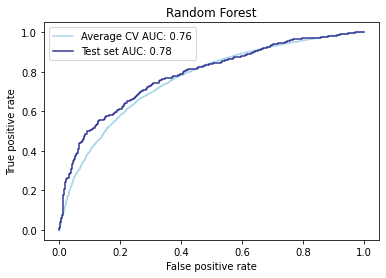

In [228]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot 

from sklearn.metrics import roc_auc_score, f1_score, matthews_corrcoef
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve

ns_fpr, ns_tpr, _ = roc_curve(np.array(val_df.label), np.array(val_df.positive))
auc_ = metrics.auc(ns_fpr, ns_tpr)
print(auc_)

ns_fpr_t, ns_tpr_t, _t = roc_curve(np.array(test_df.label), np.array(test_df.positive))
auc_t = metrics.auc(ns_fpr_t, ns_tpr_t)
print(auc_t)

#print(nameC1)
pyplot.plot(ns_fpr, ns_tpr, label='Average CV AUC: ' + str(round(auc_,2)), color="#ABD9E9"
           )
pyplot.plot(ns_fpr_t, ns_tpr_t, label='Test set AUC: ' + str(round(auc_t,2)), color="#313695"
           )
plt.legend(loc='best')

#plt.show()
plt.title('Random Forest')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.clf
plt.savefig('data/plots/roc_randomforest_new.svg', dpi=500)



In [30]:
train_cm = confusion_matrix(np.array(val_df.label), np.array(val_df.pred))
print(train_cm)
val_cm =confusion_matrix(np.array(test_df.label), np.array(test_df.pred))
print(val_cm)

[[3295 1079]
 [1808 3198]]
[[539 141]
 [258 426]]


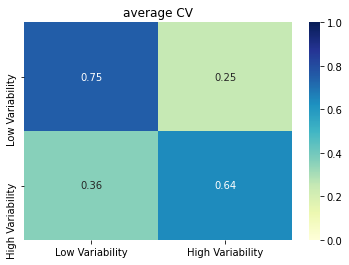

In [229]:
locations = ['Low Variability', 'High Variability']
df_norm_train = pd.DataFrame(train_cm,index=locations, columns=locations)
df_norm_train_normalized = df_norm_train.astype('float') / df_norm_train.sum(axis=1)[:, np.newaxis]
df_norm_train_normalized = round(df_norm_train_normalized,2)
sns.heatmap(df_norm_train_normalized, annot=True, fmt="g", cmap='YlGnBu', vmin=0, vmax=1)
plt.title('average CV')
plt.savefig('data/plots/cm_randomforest_val.svg', dpi=500)

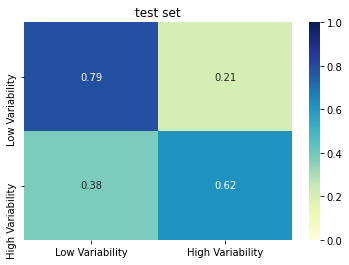

In [230]:
locations = ['Low Variability', 'High Variability']
df_norm_val = pd.DataFrame(val_cm,index=locations, columns=locations)
df_norm_val_normalized = df_norm_val.astype('float') / df_norm_val.sum(axis=1)[:, np.newaxis]
df_norm_val_normalized = round(df_norm_val_normalized,2)
sns.heatmap(df_norm_val_normalized, annot=True, fmt="g", cmap='YlGnBu', vmin=0, vmax=1)
plt.title('test set')
plt.savefig('data/plots/cm_randomforest_test.svg', dpi=500)

In [33]:
F1_weighted = f1_score(np.array(val_df.label), np.array(val_df.pred), average='weighted')
F1_weighted_test = f1_score(np.array(test_df.label), np.array(test_df.pred), average='weighted')
F1_ = f1_score(np.array(val_df.label), np.array(val_df.pred), average=None)  
F1_t = f1_score(np.array(test_df.label), np.array(test_df.pred), average=None)  

In [34]:
F1_weighted_test

0.7053849297318548

In [35]:
F1_df = pd.DataFrame([F1_,F1_t], index=['Average CV', 'Test set'], columns=['Low Variability', 'High Variability'])

In [36]:
F1_df.T

,Average CV,Test set
Low Variability,0.695368,0.729858
High Variability,0.689001,0.681055


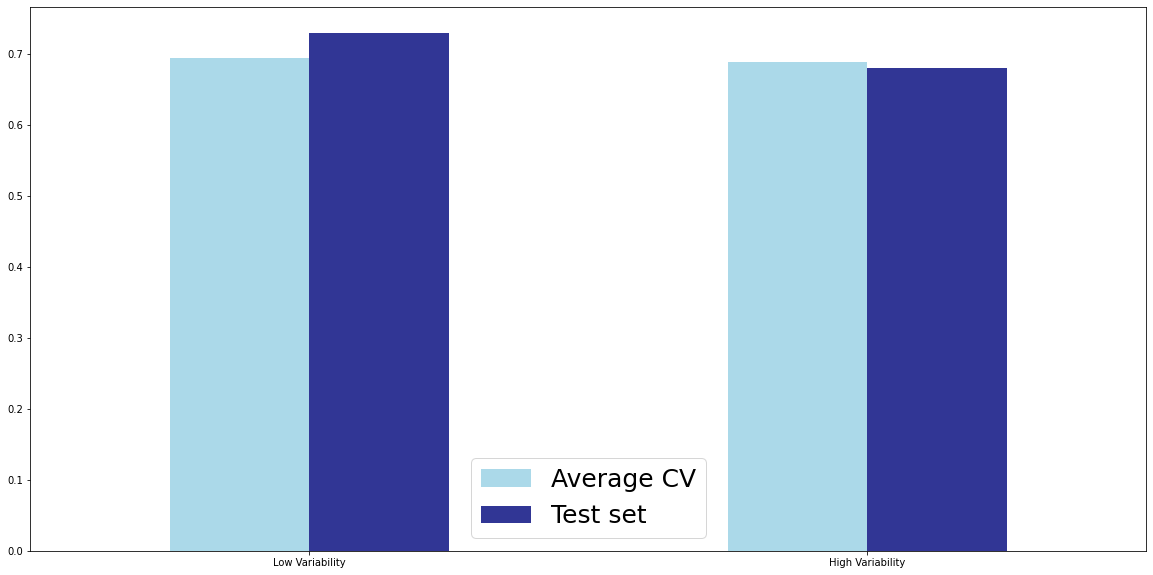

In [232]:
my_colors = ["#ABD9E9","#313695"]
F1_df.T.plot(y=["Average CV", "Test set"], kind="bar", color=my_colors, fontsize=10, rot=0, figsize=(20,10)) 
plt.legend(loc='best', fontsize=25)
#plt.tight_layout()
plt.savefig('data/plots/f1_randomforest.svg', dpi=500)

In [41]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(data.iloc[:, 1:-2])
#explainer = shap.Explainer(forest, df_all.iloc[:, 7:-1])
#shap_values = explainer(df_all.iloc[:, 7:-1])


In [160]:
def mean_shap(tf, average_shap):
    c = 0
    for i in data.iloc[:, 1:-2].columns:
        c += 1
        #print(c)
        if i == tf: 
            #print(i)
            tf_list.append(i)
            #print(shap_values[1][df_all.loc[df_all[i] == 1].index][:, c-7].mean())
            mean_ = shap_values[1][data.loc[data[i] == 1].index][:, c-1].mean()
            average_shap.append(mean_)
    return average_shap, tf_list

In [161]:
def freq_shap(tf, label, frequency_shap):
    c = 0
    for i in data.iloc[:, 1:-2].columns:
        c += 1
        if i == tf: 
            #mean_ = shap_values[1][df_all.loc[df_all[i] == 1].index][:, c-7].shape[0]
            presence = data.loc[(data[i] == 1) & (data['Class_'] == label)].shape[0]
            all_count = data.loc[data['Class_'] == label].shape[0]
            frequency = (presence/all_count)
            frequency_shap.append(frequency)
    return frequency_shap

In [162]:
tfs_list = data.iloc[:, 1:-2].columns
average_shap = list()
for tf in tfs_list:
    final_tf_list, id_tf_list = mean_shap(tf, average_shap)

In [164]:
# compute frequency for low  and high variable promoters
frequency_shap = list()
frequency_shap1 = list()
tfs_list = data.iloc[:, 1:-2].columns
for tf in tfs_list:
    final_tf_list_fl = freq_shap(tf,0,frequency_shap)
    final_tf_list_fh = freq_shap(tf,1,frequency_shap1)

In [179]:
df_shap = pd.DataFrame(final_tf_list, index=data.iloc[:, 1:-2].columns, columns=['Feature'])
df_shap_fl = pd.DataFrame(final_tf_list_fl, index=data.iloc[:, 1:-2].columns, columns=['Feature'])
df_shap_fh = pd.DataFrame(final_tf_list_fh, index=data.iloc[:, 1:-2].columns, columns=['Feature'])

In [180]:
shap_m = df_shap.sort_values(by=['Feature'], ascending=False)
freq_l = df_shap_fl.sort_values(by=['Feature'], ascending=False)
freq_h = df_shap_fh.sort_values(by=['Feature'], ascending=False)

In [185]:
freq_l = freq_l.reindex(list(shap_m.index))
freq_h = freq_h.reindex(list(shap_m.index))

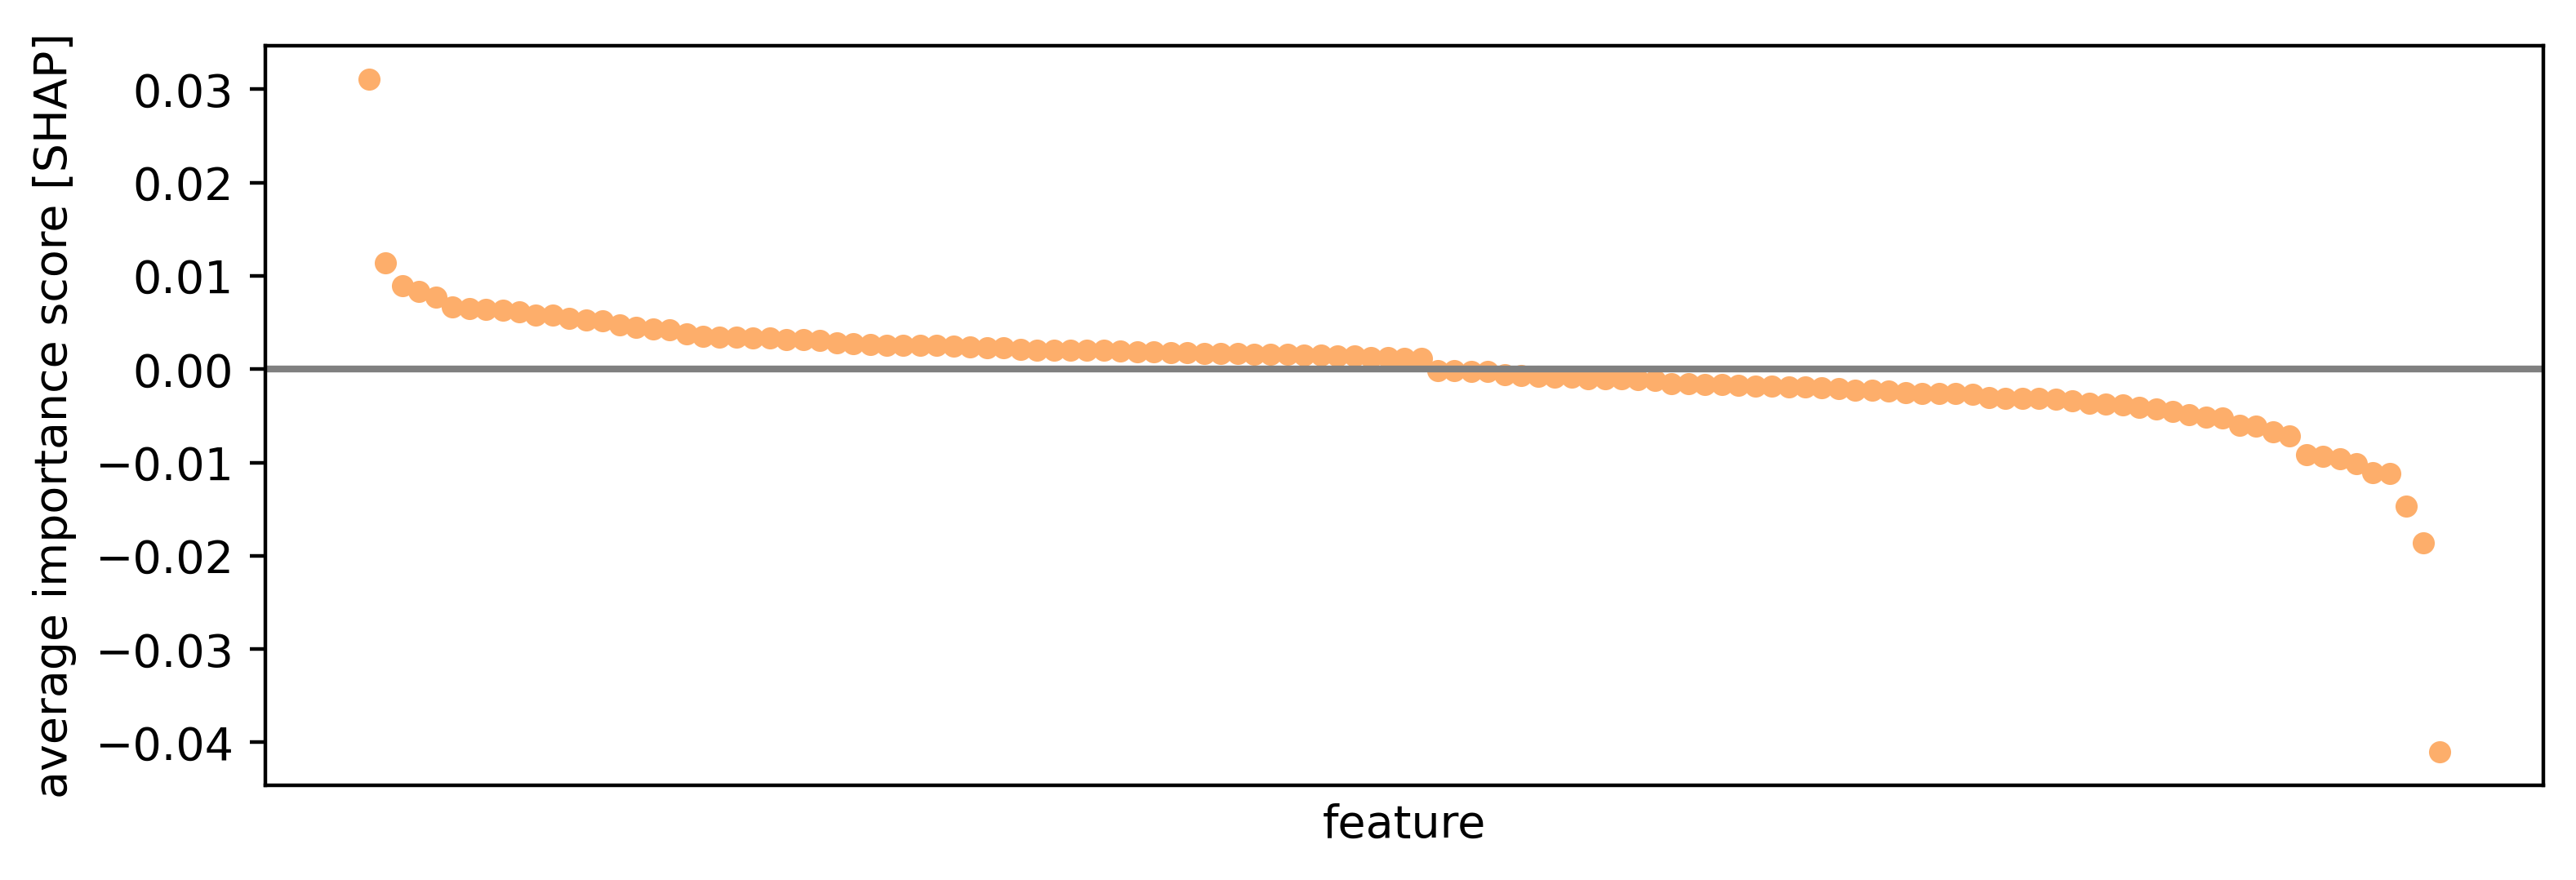

In [234]:
fig, ax = plt.subplots(figsize=(9,3), dpi= 400)
ax.vlines(x=shap_m.index, ymin=-0.001215, ymax=0.001513, color='#fdae6b', alpha=0.7, linewidth=0.0)
ax.scatter(x=shap_m.index, y=shap_m.Feature, s=15, color='#fdae6b')#,alpha=0.9)

# Title, Label, Ticks and Ylim
#ax.set_title('Lollipop Chart for Highway Mileage', fontdict={'size':22})
ax.set_ylabel('average importance score [SHAP]')
ax.set_xlabel('feature')
#ax.set_xticks(aa.index)
#ax.set_xticklabels(aa.index, rotation=90, fontdict={'horizontalalignment': 'right', 'size':5})
#ax.set_xticklabels(df.manufacturer.str.upper(), rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
#ax.set_ylim(0, 30)
ax.set_facecolor('white')
ax.set_xticks([])
plt.axhline(0, color='grey')
#plt.tight_layout()
#plt.show()
plt.savefig('data/plots/shap_plot_average.pdf', dpi=500)

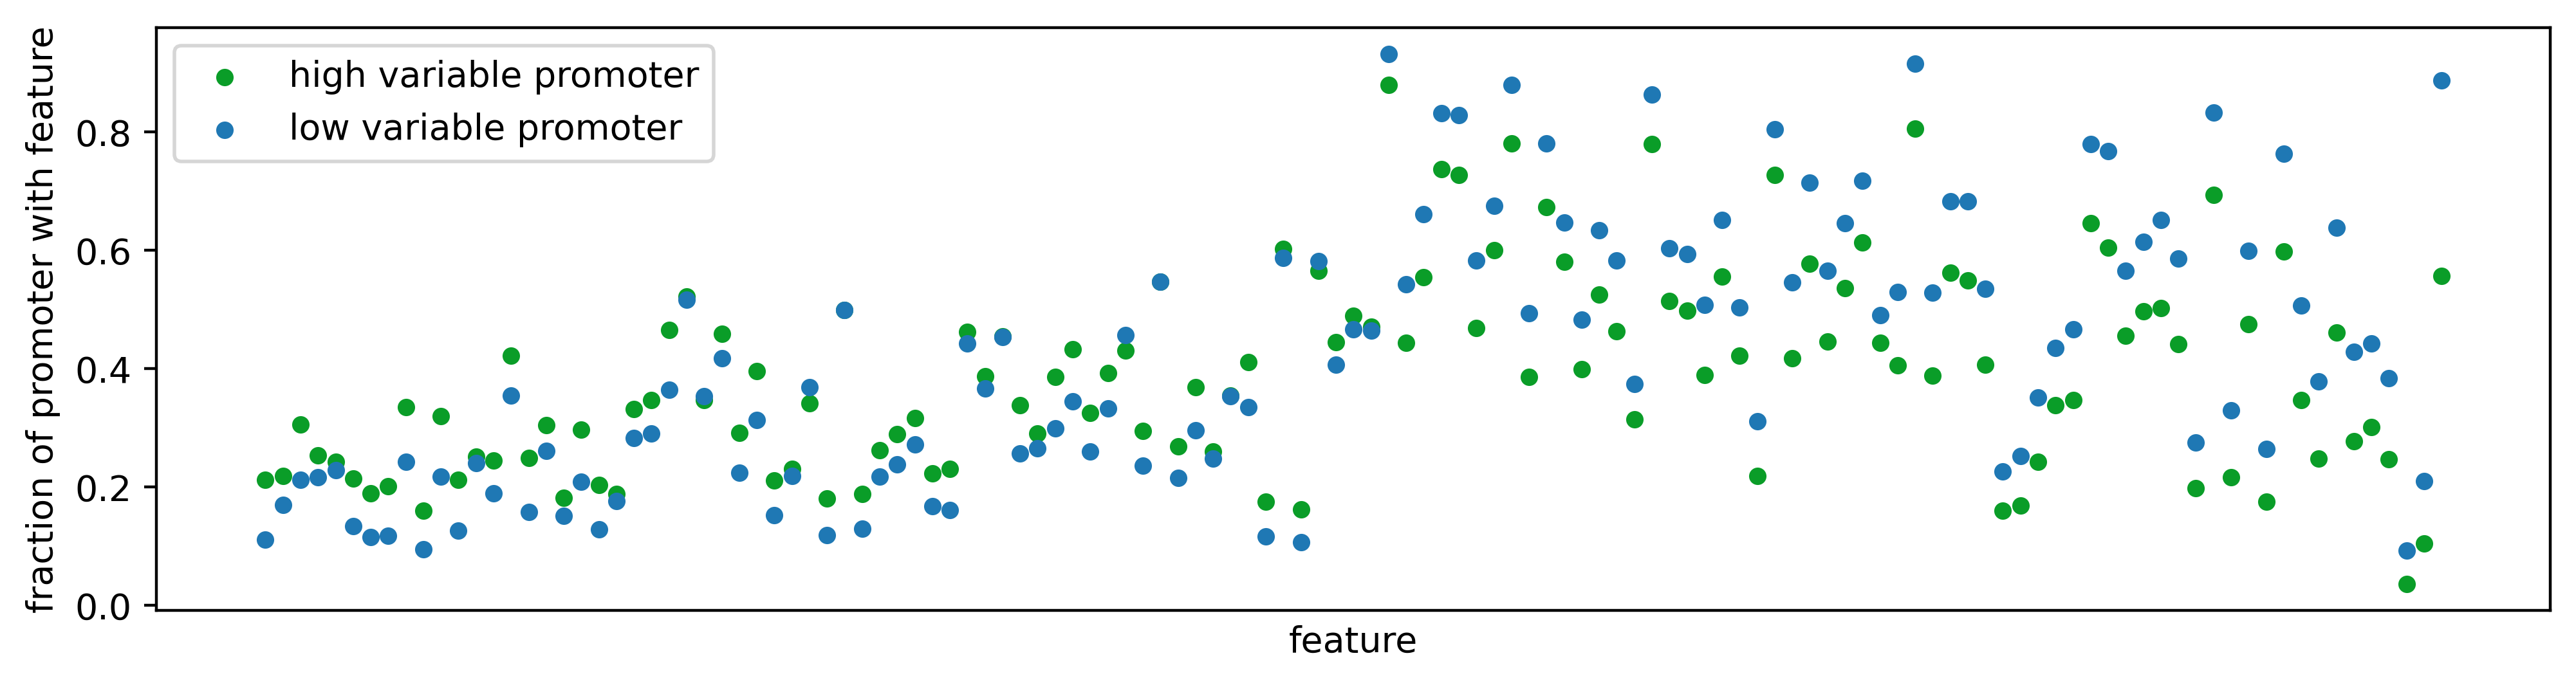

In [236]:
fig, ax = plt.subplots(figsize=(12,3), dpi= 400)
#ax.vlines(x=aa2.index, ymin=0.036783, ymax=0.916767, color='#fc8d59', alpha=0.7, linewidth=0.0)
ax.scatter(x=freq_h.index, y=freq_h.Feature, s=15, color='#0a9d28', label='high variable promoter') #,alpha=0.9
ax.scatter(x=freq_l.index, y=freq_l.Feature, s=15, color='#1f78b4', label='low variable promoter') #,alpha=0.9
# Title, Label, Ticks and Ylim
ax.set_ylabel('fraction of promoter with feature')
ax.set_xlabel('feature')
#ax.set_xticks(aa.index)
#ax.set_xticklabels(aa.index, rotation=90, fontdict={'horizontalalignment': 'right', 'size':5})
#ax.set_ylim(0, 30)
ax.set_facecolor('white')
ax.set_xticks([])
# Turn off axes and set axes limits
ax.axis('tight')
#ax.axis('off')
plt.legend(loc='best')
#plt.axhline(0, color='grey')
#plt.tight_layout()

#plt.show()
plt.savefig('data/plots/shap_plot_frequency_all.pdf', dpi=500)

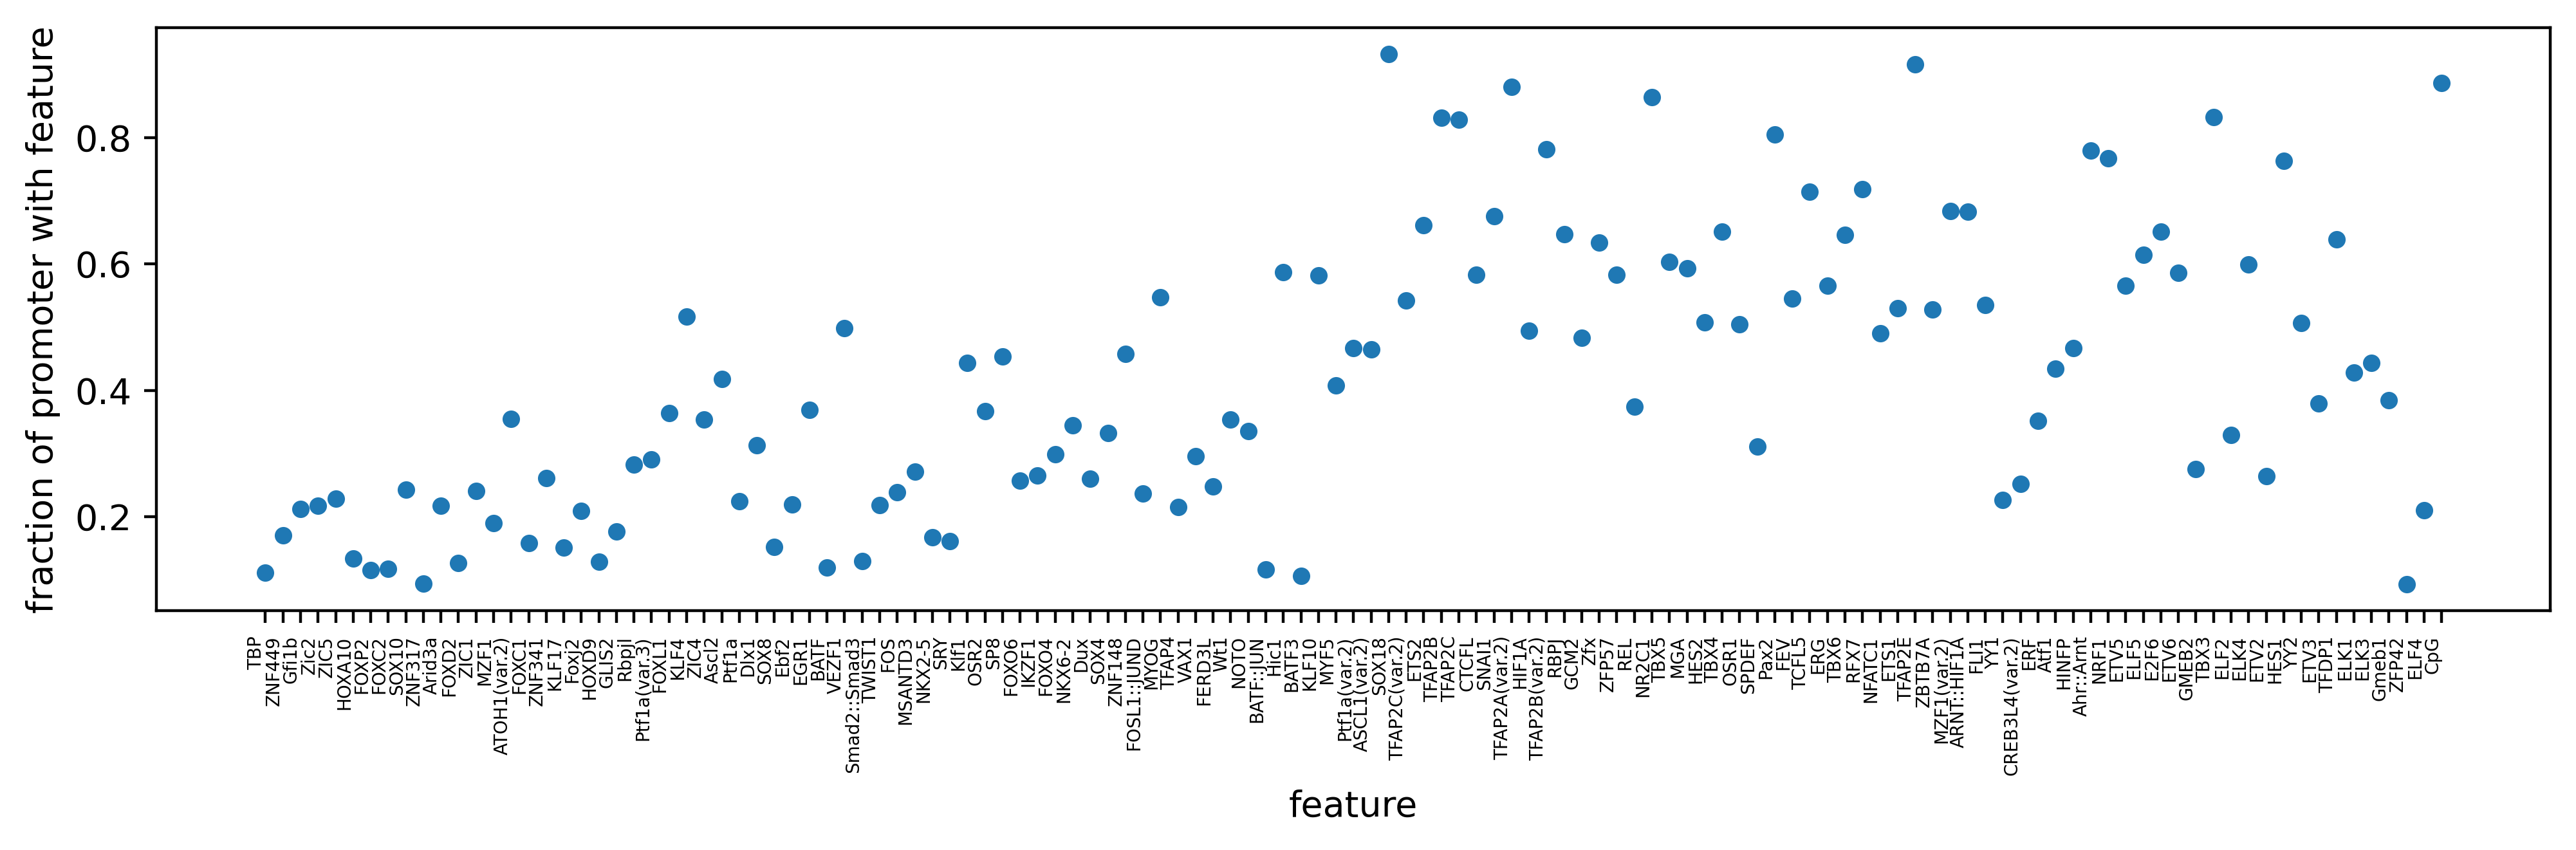

In [238]:
fig, ax = plt.subplots(figsize=(12,3), dpi= 400)
ax.scatter(x=freq_l.index, y=freq_l.Feature, s=15, color='#1f78b4')#,alpha=0.9)#, label='low variability')
# Title, Label, Ticks and Ylim
ax.set_ylabel('fraction of promoter with feature')
ax.set_xlabel('feature')
ax.set_xticks(aa.index)
ax.set_xticklabels(aa.index, rotation=90, fontdict={'horizontalalignment': 'right', 'size':5})
#ax.set_ylim(0, 30)
ax.set_facecolor('white')
#ax.set_xticks([])
# Turn off axes and set axes limits
ax.axis('tight')
#ax.axis('off')
#plt.legend(loc='best')
#plt.tight_layout()
#plt.show()
plt.savefig('data/plots/shap_plot_frequency_low.pdf', dpi=500)

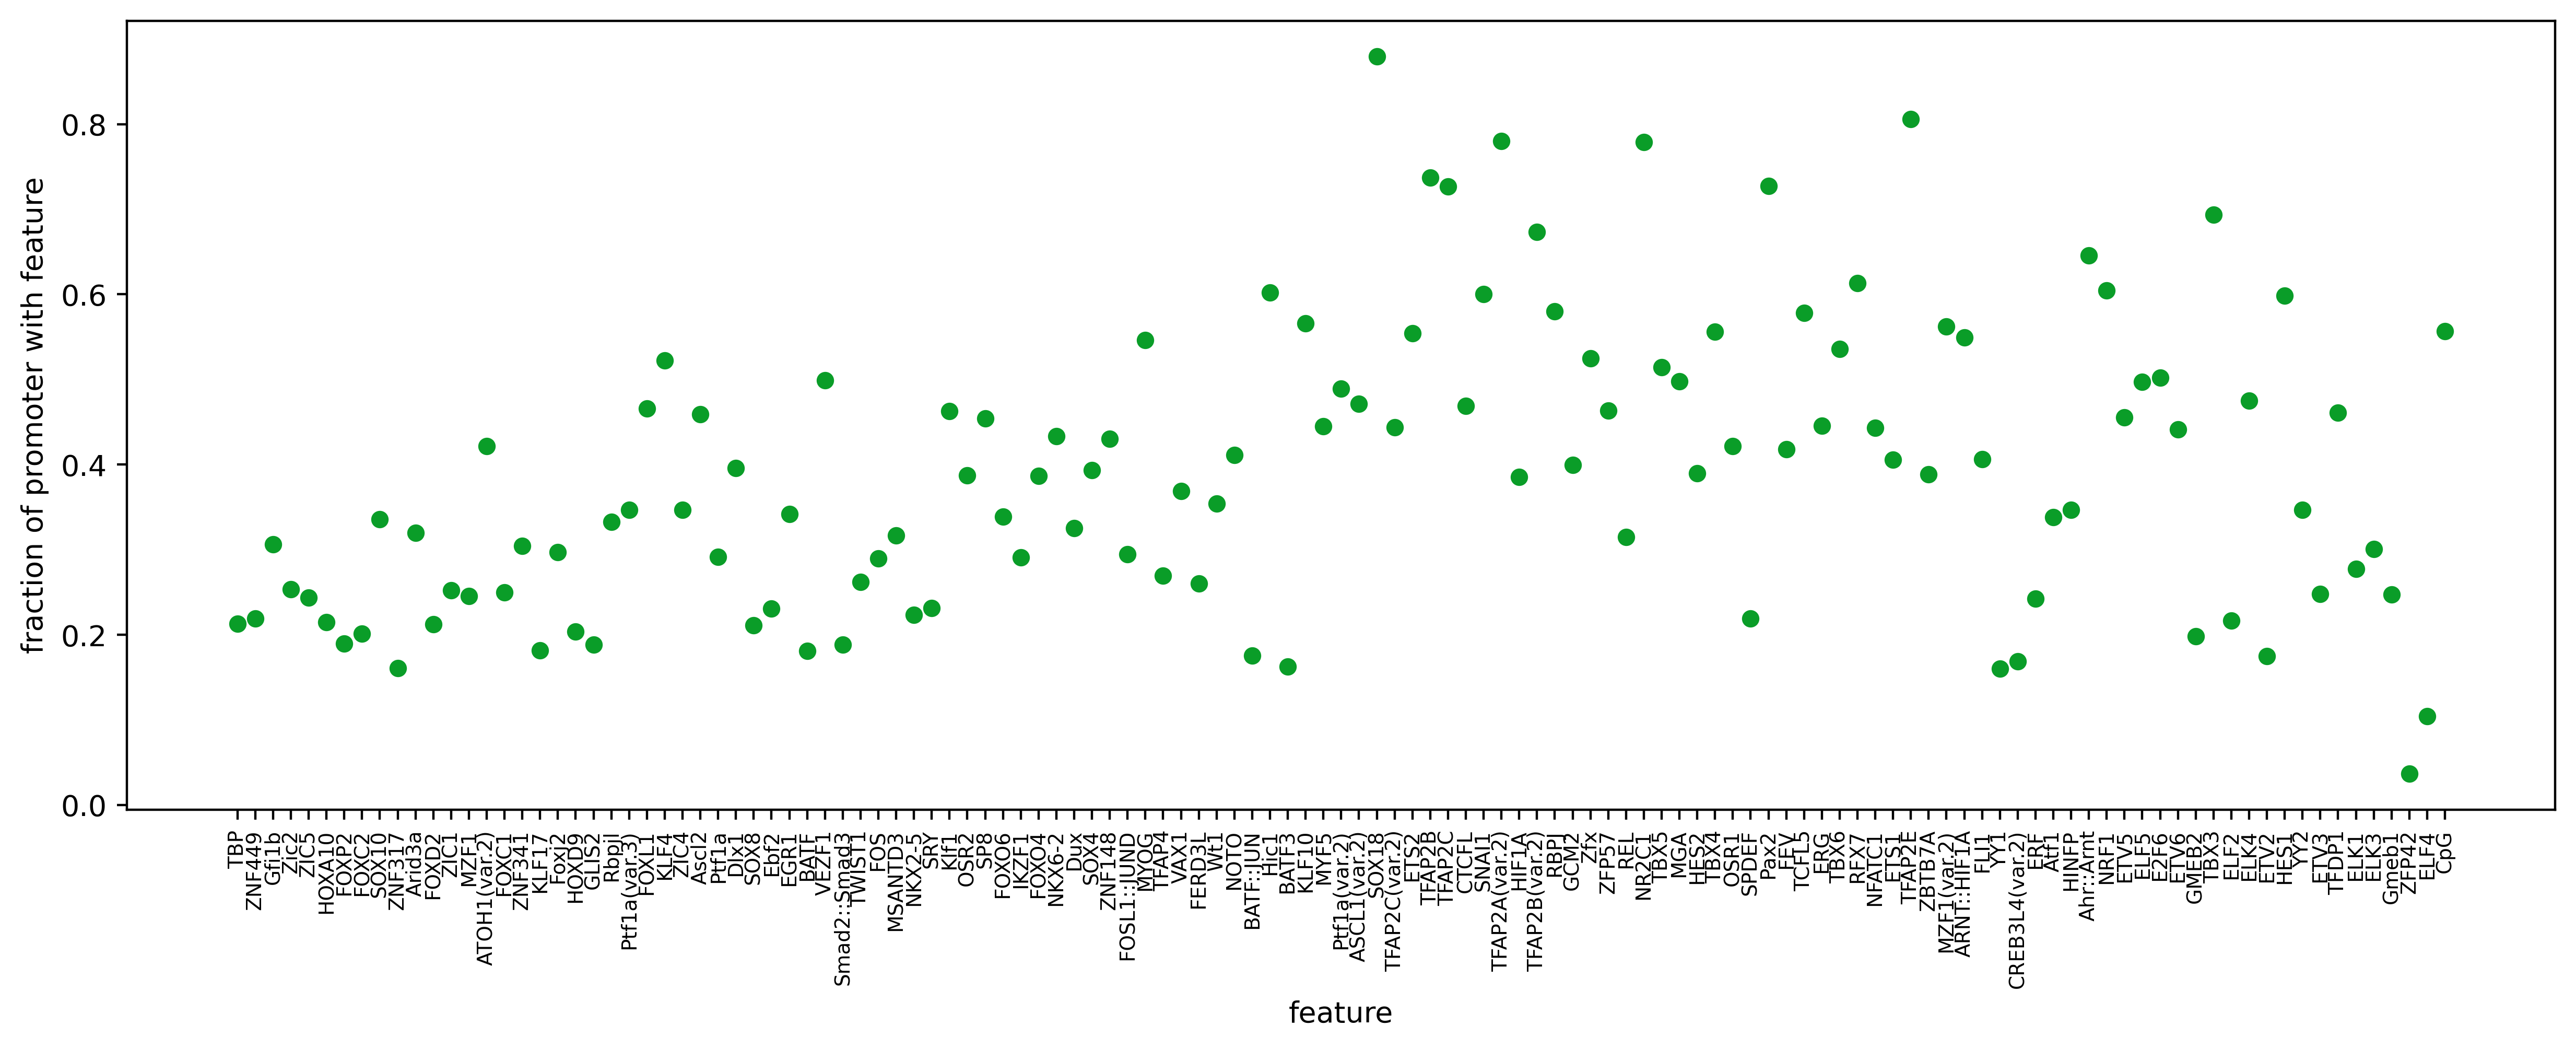

In [240]:
fig, ax = plt.subplots(figsize=(15,5), dpi= 400)
#ax.vlines(x=aa2.index, ymin=0.036783, ymax=0.916767, color='#fc8d59', alpha=0.7, linewidth=0.0)
ax.scatter(x=freq_h.index, y=freq_h.Feature, s=25, color='#0a9d28')#,alpha=0.9)#, label='high variability')
#ax.scatter(x=aa1aa.index, y=aa1aa.Feature, s=15, color='#1f78b4',alpha=0.9, label='low variability')


# Title, Label, Ticks and Ylim
#ax.set_title('Lollipop Chart for Highway Mileage', fontdict={'size':22})
ax.set_ylabel('fraction of promoter with feature')
ax.set_xlabel('feature')
#ax.set_xticks(aa.index)
ax.set_xticklabels(aa.index, rotation=90, fontdict={'size':7})
#ax.set_xticklabels(df.manufacturer.str.upper(), rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
#ax.set_ylim(0, 30)
ax.set_facecolor('white')
#ax.set_xticks([])
# Turn off axes and set axes limits
ax.axis('tight')
#ax.axis('off')
#plt.legend(loc='best')
#plt.axhline(0, color='grey')
#plt.tight_layout()

#plt.show()
plt.savefig('data/plots/shap_plot_frequency_high.pdf', dpi=500)

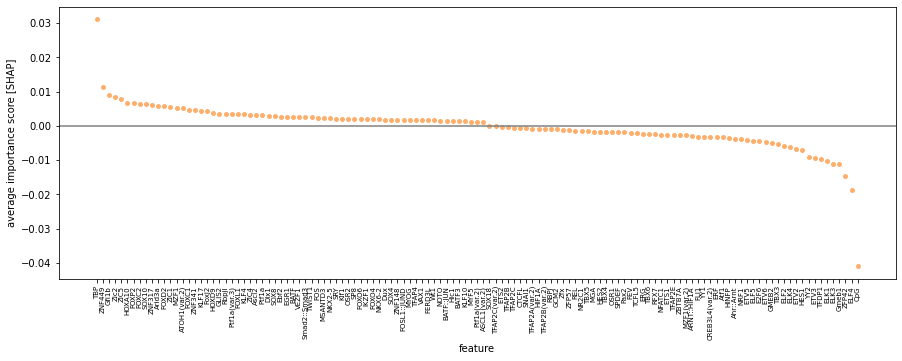

In [242]:
fig, ax = plt.subplots(figsize=(15,5))
#ax.vlines(x=shap_m.index, ymin=-0.001215, ymax=0.001513, color='#fdae6b', alpha=0.7, linewidth=0.0)
ax.scatter(x=shap_m.index, y=shap_m.Feature, s=15, color='#fdae6b')#,alpha=0.9)

# Title, Label, Ticks and Ylim
ax.set_ylabel('average importance score [SHAP]')
ax.set_xlabel('feature')
#ax.set_xticks(aa.index)
ax.set_xticklabels(aa.index, rotation=90, fontdict={'size':7})
#ax.set_ylim(0, 30)
ax.set_facecolor('white')
#ax.set_xticks([])
plt.axhline(0, color='grey')
#plt.tight_layout()

#plt.show()
plt.savefig('data/plots/shap_plot_average_all.pdf', dpi=500)